In [43]:
import geopandas as gpd
from shapely.geometry import LineString
import pandas as pd
import networkx as nx
import sqlite3
import matplotlib.pyplot as plt

In [64]:
with sqlite3.connect('Dataset/submarine_cable.sqlite') as con:
    c = con.cursor()
    cable_coor = pd.read_sql("select distinct geometry from landing_points left join cable_coor on cable_id = id where id = '2africa'",con=con)
# cable_shap = gpd.GeoDataFrame(cable_coor, crs=4326)

In [65]:
cleaned_cable_coor = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")
# coor_list = cleaned_cable_coor.iloc[0].split(', (')
cleaned_cable_coor

/var/folders/93/98m4gg790h36hw_xcd31b1d40000gn/T/ipykernel_26161/4183496804.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  cleaned_cable_coor = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")


0    55.350035025455725 26.26024097157773, 54.90003...
Name: geometry, dtype: object

In [45]:
cleaned_cable_coor = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")

coor_list = cleaned_cable_coor.iloc[0].split(', (')

data = pd.DataFrame()


for x in coor_list:
    seg = pd.DataFrame()
    abc = x.split(', ')
    # print(abc)
    for y in abc:
        a = {'lon1': y.split(' ')[0], 'lat1': y.split(' ')[1]}
        seg = seg.append(a,ignore_index=True)
    seg["lon1"] = seg["lon1"].astype("float64")
    seg["lat1"] = seg["lat1"].astype("float64")
    seg['lon2'] = seg['lon1'].shift()
    seg['lat2'] = seg['lat1'].shift()
    data = data.append(seg.dropna(),ignore_index=True)
data
# data['lon2'] = data['lon1'] - data['lon1'].shift()

/var/folders/93/98m4gg790h36hw_xcd31b1d40000gn/T/ipykernel_26161/2669464575.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  cleaned_cable_coor = cable_coor["geometry"].str.replace("MULTILINESTRING \(\(", "").str.replace("\)", "").str.replace("'","")


,lon1,lat1,lon2,lat2
0,54.900035,25.754704,55.350035,26.260241
1,54.450036,24.839313,54.900035,25.754704
2,54.419076,24.443965,54.450036,24.839313
3,60.975031,16.318380,60.525031,16.102326
4,66.600027,18.251816,60.975031,16.318380
...,...,...,...,...
215,-9.337919,38.688829,-10.799918,38.475881
216,5.400070,2.367913,3.825072,4.164913
217,7.200069,1.243490,5.400070,2.367913
218,8.550068,1.018534,7.200069,1.243490


In [46]:
# data['lon2'] = data['lon1'].shift()
# data['lat2'] = data['lat1'].shift()
# data["lon1"] = data["lon1"].astype("float64")
# data["lat1"] = data["lat1"].astype("float64")

In [47]:
data.dropna()
gdf = gpd.GeoDataFrame(data)
    # data,geometry=gpd.points_from_xy(data.lon1, data.lat1), crs=4326)
gdf['fr_point'] = gpd.points_from_xy(x=gdf['lon1'],y=gdf['lat1'])
gdf['to_point'] = gpd.points_from_xy(x=gdf['lon2'],y=gdf['lat2'])
gdf['fr_id'] = round((round(gdf['lon1'],4) + round(gdf['lat1'],4))*10000,0)
gdf['to_id'] = round((round(gdf['lon2'],4) + round(gdf['lat2'],4))*10000,0)
gdf['distance_from_previous'] = gdf['fr_point'].distance(gdf['to_point'])

# gdf['distance_from_previous'] = gdf.distance(gdf.shift(1))

In [48]:
gdf = gdf.iloc[1::,]
gdf['line'] = gdf.apply(lambda row: LineString([row['fr_point'], row['to_point']]), axis=1) #Create a linestring column
geo_df = gpd.GeoDataFrame(gdf, geometry=gdf['line'])

<AxesSubplot:>

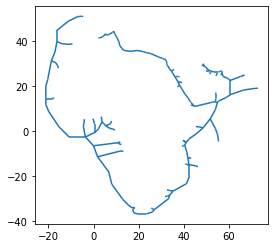

In [49]:
gdf.plot()

In [50]:
gdf = gdf.reset_index( )


In [51]:
# gdf.to_csv('/Users/dijiongyuequ/Downloads/234.csv')

In [52]:
G = nx.from_pandas_edgelist(gdf, 'fr_id', 'to_id', edge_attr=['index', 'distance_from_previous'], create_using=nx.Graph)


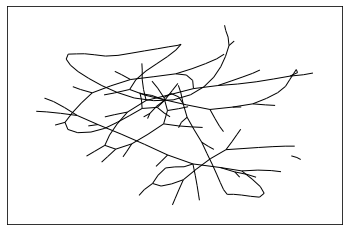

In [53]:
nx.draw_networkx_edges(G, pos=nx.spring_layout(G))


In [54]:
path = nx.shortest_path(G,816840,56755, weight = 'length')

# def getPath(path, road):
#     pathroad = pd.DataFrame()
#     for i in range(5):
#         # len(path.keys())-1
#         node1 = path[list (path.keys())[i]]
#         print(node1)
#         node2 = path[list (path.keys())[i+1]]
#         print(node2)
#         r = road[(road['fr_id'] == node1) & (road['to_id'] == node2)]
#         pathroad = pathroad.append(r)
#     return pathroad

def getPath(path, road):
    pathroad = pd.DataFrame()
    for i in range(len(path)-1):
        # len(path.keys())-1
        node1 = path[i]
        node2 = path[i+1]
        r = road[(road['fr_id'] == node1) & (road['to_id'] == node2)]
        pathroad = pathroad.append(r)
    return pathroad

<AxesSubplot:>

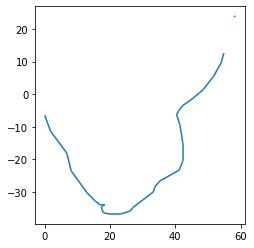

In [55]:
path_road = getPath(path, gdf)
path_road.plot()


In [56]:
# cable_shap.plot()

# fig     = plt.figure(figsize=(15,10),dpi = 200)
# ax      = plt.subplot(111)
# cable_shap.plot(column='color', ax=ax, legend=True, cmap='Set2',aspect=1)


In [57]:
# landing_point = gpd.read_file("/Users/dijiongyuequ/Downloads/GitHub/UCL_Dessertation/Dataset/SubmarineCableMap/cable-geo.json")
# landing_point.to_csv("/Users/dijiongyuequ/Downloads/123.csv")